# Introduction

Tasty Bytes is a recipe website that generates significant engagement when a popular recipe is featured on the homepage. The product team has observed that featuring a well-liked recipe can boost traffic to the rest of the site by as much as 40%, which directly supports the company’s subscription-based business model.

Currently, recipe selection for the homepage is based on personal preference. However, there is a need to make this process more data-driven. The goal of this project is to build a model that can predict whether a recipe is likely to result in **high website traffic** when featured on the homepage. Ideally, this model should be able to correctly identify popular recipes **at least 80% of the time**.

In this project, I:
- Validated and cleaned the recipe dataset provided by the product team.
- Conducted exploratory analysis to understand the drivers of recipe popularity.
- Developed and compared classification models to predict recipe success.
- Defined a performance metric the business can monitor going forward.
- Provided actionable recommendations based on the findings.

The rest of this report details the data preparation, analysis, modeling process, evaluation, and business recommendations.

In [ ]:
# Importing Libraries
# Data Wrangling and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Statistical Analysis
from scipy import stats
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

# Preprocessing
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from scipy.stats.mstats import winsorize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, accuracy_score,
precision_score, recall_score, f1_score, average_precision_score)
from sklearn.metrics import roc_curve, precision_recall_curve

# Cross-validation and grid search (for hyperparameter tuning)
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold

# Misc
from itertools import combinations
import json

### Customizations

In [ ]:
# Set universal font settings
mpl.rcParams['font.family'] = 'Liberation Sans'

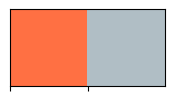

In [ ]:
# Define color palette
traffic_palette = {'High': '#FF7043', 'Low': '#B0BEC5'}

sns.palplot([traffic_palette['High'], traffic_palette['Low']])

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Loading the dataset

In [ ]:
url = "https://github.com/kofoworola-e/tasty_bytes_datacamp/raw/refs/heads/main/data/recipe_site_traffic_2212.csv"
df = pd.read_csv(url)
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


# Data Validation and Cleaning

Before beginning exploratory analysis and modeling, I validated and cleaned the dataset to ensure data quality. Below is a detailed summary by column:

**`recipe`**
- **Type**: Integer.
- **Validation**: All 947 values are non-null and unique, confirming it is a valid identifier.
- **Action**: No cleaning necessary.

**`calories`, `carbohydrate`, `sugar`, `protein`**
- **Type**: Float.
- **Validation**:
  - These columns each have 895 non-null values, meaning **52 rows are missing** nutritional data.
  - The values span a wide range, with some large values that are plausible but may influence model performance.
- **Action**:
  - Rows with missing values in any of these columns will be dropped for simplicity and consistency.
  - Distribution plots and outlier detection will be considered during EDA to decide if further treatment is needed.

**`category`**
- **Type**: Object (categorical).
- **Validation**:
  - 947 non-null values.
  - Found 11 unique values, including a potential duplicate: `'Chicken Breast'` vs `'Chicken'`.
- **Action**:  
  - Standardized `'Chicken Breast'` to `'Chicken'` since `'Chicken Breast'` is not one of the listed categories Tasty Bytes officially offers (as inferred from the data dictionary). This ensures consistency with the defined category schema.

**`servings`**
- **Type**: Object.
- **Validation**:
  - 947 non-null values, but a mix of formats: some entries are numeric strings (`'4'`, `'6'`), while others include text (`'4 as a snack'`).
- **Action**:
  - Extracted the numeric part of the serving value and converted the column to numeric type.

**`high_traffic`**
- **Type**: Object (binary categorical).
- **Validation**:
  - 574 non-null values. The rest are missing, representing ~39% of the data.
  - Only one category observed: `'High'`. Missing values implicitly represent non-high traffic.
- **Action**:
  - Converted to binary format: `'High'` = 1, `NaN` = 0.
  - Renamed column to `high_traffic_flag` for clarity during modeling.


## Inspection

In [ ]:
# Checking structure, dtypes and missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [ ]:
# Duplicates check
df.duplicated().sum()

np.int64(0)

In [ ]:
num_cols = ['calories', 'carbohydrate', 'sugar', 'protein']

In [ ]:
# Statistical summary of numerical cols
df[num_cols].describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296
std,453.020997,43.949032,14.679176,36.369739
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,3633.160000,530.420000,148.750000,363.360000


In [ ]:
for col in ['category', 'servings', 'high_traffic']:
    print(f"{col}:")
    print(df[col].unique())
    print()

category:
['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']

servings:
['6' '4' '1' '2' '4 as a snack' '6 as a snack']

high_traffic:
['High' nan]



## Data Cleaning

In [ ]:
# Drop missing rows with missing nutritional values
df = df.dropna(subset=['calories', 'carbohydrate', 'sugar', 'protein'])

In [ ]:
# Replace 'Chicken Breast' with 'Chicken' for consistency
df.loc[:, 'category'] = df['category'].replace('Chicken Breast', 'Chicken')

In [ ]:
df['servings'] = df['servings'].str.extract(r'(\d+)').astype(int)

<ipython-input-189-b1c3c545496b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['servings'] = df['servings'].str.extract(r'(\d+)').astype(int)


In [ ]:
# Create a binary column for 'high_traffic' (1 if High, 0 if not High or missing)
df.loc[:, 'high_traffic'] = df['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)

# rename high_traffic to high_traffic_flag
df.rename(columns={'high_traffic': 'high_traffic_flag'}, inplace=True)

df['high_traffic_flag'] = df['high_traffic_flag'].astype(int)

## Final Inspection

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 895 entries, 1 to 946
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recipe             895 non-null    int64  
 1   calories           895 non-null    float64
 2   carbohydrate       895 non-null    float64
 3   sugar              895 non-null    float64
 4   protein            895 non-null    float64
 5   category           895 non-null    object 
 6   servings           895 non-null    int64  
 7   high_traffic_flag  895 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 62.9+ KB


In [ ]:
df.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic_flag
275,276,597.55,19.65,6.19,6.63,Lunch/Snacks,6,1
791,792,28.99,46.40,7.14,0.22,Beverages,6,0
819,820,600.24,51.08,18.07,5.91,Dessert,4,1
65,66,260.33,0.51,1.24,4.53,Dessert,1,0
899,900,35.81,3.38,0.07,0.12,Beverages,6,0
27,28,574.75,13.12,1.84,13.85,Potato,4,1
406,407,169.83,42.42,1.98,31.10,Meat,4,1
878,879,88.26,18.58,5.21,99.64,Meat,6,1
646,647,813.82,33.77,1.68,1.01,Chicken,4,0
341,342,23.64,102.52,14.22,61.22,One Dish Meal,4,1


In [ ]:
# Load raw data for comparison
df_before = pd.read_csv(url)

# Function to count missing values
def missing_summary(df):
    return df.isnull().sum().to_frame(name='Missing').assign(Percent=lambda x: (x['Missing'] / len(df)) * 100)

# Get missing summary before cleaning
missing_before = missing_summary(df_before).rename(columns={'Missing': 'Missing (Before)', 'Percent': 'Percent (Before)'})

# Get missing summary after cleaning
missing_after = missing_summary(df).rename(columns={'Missing': 'Missing (After)', 'Percent': 'Percent (After)'})

# Combine into one table
missing_comparison = missing_before.join(missing_after)
missing_comparison = missing_comparison.fillna(0)
missing_comparison = missing_comparison.astype(int)

missing_comparison

,Missing (Before),Percent (Before),Missing (After),Percent (After)
recipe,0,0,0,0
calories,52,5,0,0
carbohydrate,52,5,0,0
sugar,52,5,0,0
protein,52,5,0,0
category,0,0,0,0
servings,0,0,0,0
high_traffic,373,39,0,0


# Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is an essential step in understanding the structure, distribution, and relationships within the dataset. In this analysis, I will:

1. **Examine the distribution of nutritional features** (calories, carbohydrates, sugar, and protein) across the recipes to understand the spread, central tendency, and presence of any outliers.
2. **Analyze traffic patterns** by comparing high-traffic recipes versus low-traffic recipes. This will help us understand if there are any significant differences in nutritional values and categories between the two.
3. **Explore recipe categories** and their frequencies to identify which types of recipes are more common and whether certain categories tend to drive more traffic.

This section will provide both quantitative and visual insights, laying the foundation for building predictive models in the next phase of the analysis.

## 1. What is the ratio of high-traffic recipes to low-traffic recipes?

High-traffic recipes make up approximately 60% (535 recipes) of the Tasty Bytes database, while low-traffic recipes account for about 40% (355 recipes). This indicates that a greater share of the recipes have gained significant traction.

In [ ]:
df['high_traffic_flag'].value_counts(normalize=True).round(2)

,proportion
high_traffic_flag,
1,0.6
0,0.4


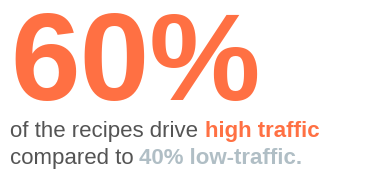

In [ ]:
# Define colors
high = traffic_palette['High']
low = traffic_palette['Low']
gray_color = '#545454'

# Create figure and axis
fig, ax = plt.subplots(figsize=(4, 2))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.axis('off')

# Add big 20%
ax.text(0, 0.7, "60%", fontsize=90, color=high,
        fontweight='bold', ha='left', va='center')

# Starting positions
start_x = 0
start_y = 0.3

# Create a renderer to measure text widths
fig.canvas.draw()
renderer = fig.canvas.get_renderer()

# --- Line 1: "of the customers" + "churned"
text1 = ax.text(start_x, start_y, "of the recipes drive ", fontsize=16, color=gray_color,
                ha='left', va='center')

bbox1 = text1.get_window_extent(renderer=renderer).transformed(ax.transData.inverted())
width1 = bbox1.width

text2 = ax.text(start_x+ + width1-0.1, start_y, "high traffic", fontsize=16, color=high,
                fontweight='bold', ha='left', va='center')

# --- Line 2: "compared to" + "80% retained"
text3 = ax.text(start_x, start_y-0.17, "compared to ", fontsize=16, color=gray_color,
                ha='left', va='center')

bbox3 = text3.get_window_extent(renderer=renderer).transformed(ax.transData.inverted())
width3 = bbox3.width

text4 = ax.text(start_x + width3-0.07, start_y-0.17, "40% low-traffic.", fontsize=16, color=low,
                fontweight='bold', ha='left', va='center')

plt.tight_layout()
plt.show()

## 2. Distribution of Nutritional Features

To understand the spread and skewness of the nutritional data, I used box plots for calories, carbohydrate, sugar, and protein. These plots reveal:

- All four features are positively skewed, meaning most values cluster toward the lower end, with a long tail stretching to the right.

- There are significant outliers in each feature, particularly for calories and protein, which range up to 3500+ and 350+ respectively.

- These characteristics indicate that typical values differ notably from the extreme ones.

This analysis reveals preprocessing actions like outlier capping, log transformations, etc that will be taken later on to prepare these features for modeling.

In [ ]:
# Nutritional columns
nutrients = ['calories', 'carbohydrate', 'sugar', 'protein']

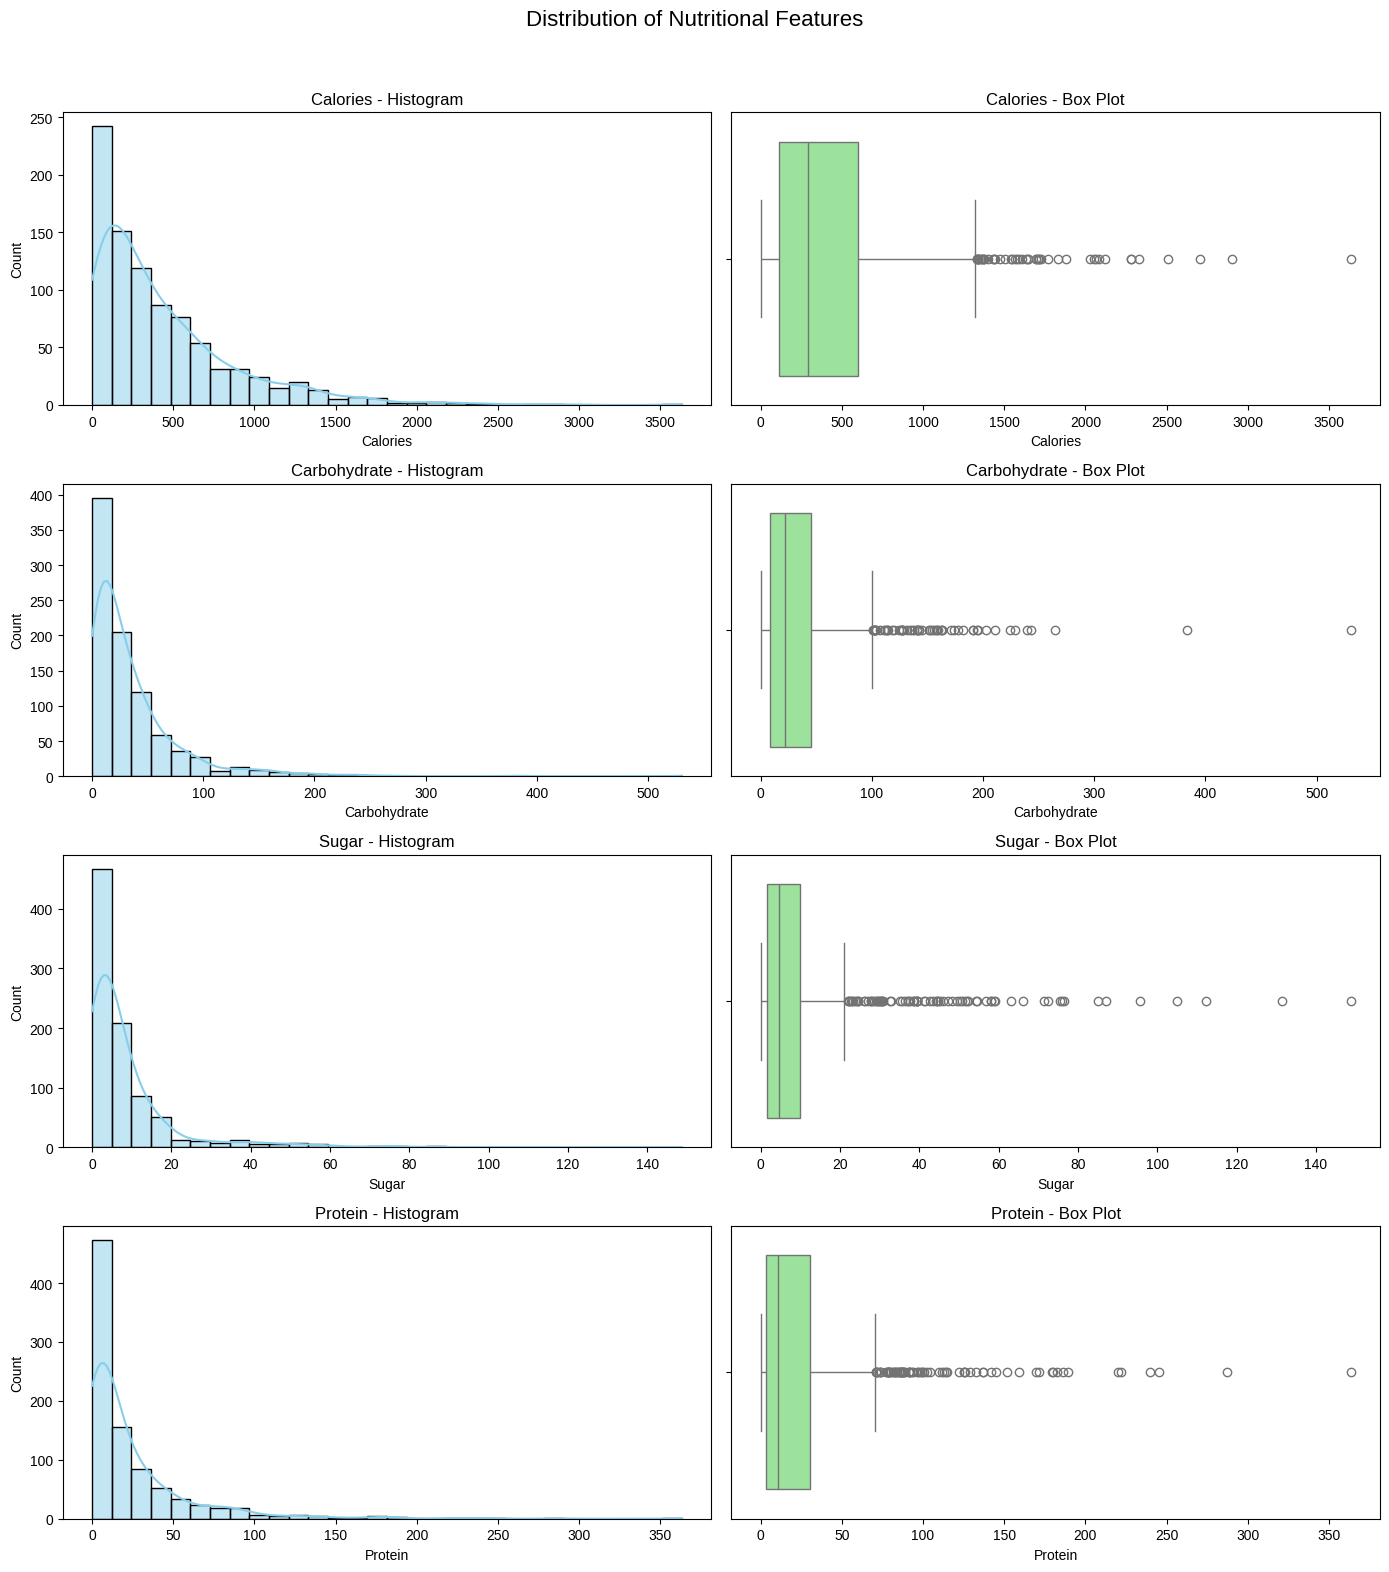

In [ ]:
# Set up grid layout for histograms and box plots
fig, axes = plt.subplots(len(nutrients), 2, figsize=(14, 16))
fig.suptitle('Distribution of Nutritional Features', fontsize=16)
fig.subplots_adjust(hspace=0.4)

for i, nutrient in enumerate(nutrients):
    # Histogram
    sns.histplot(data=df, x=nutrient, bins=30, kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'{nutrient.capitalize()} - Histogram')
    axes[i, 0].set_xlabel(nutrient.capitalize())
    axes[i, 0].set_ylabel('Count')

    # Box plot
    sns.boxplot(data=df, x=nutrient, ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'{nutrient.capitalize()} - Box Plot')
    axes[i, 1].set_xlabel(nutrient.capitalize())

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3. Correlation Analysis

To understand whether nutritional content influences a recipe’s popularity, I examined the relationships between **traffic level** (high or low) and key nutritional features: calories, carbohydrate, sugar, and protein.

I used two approaches:
- **Pearson correlation** to explore general relationships between all numerical features.
- **Point-Biserial correlation** to assess how each nutrient correlates with the binary **high traffic** label.

#### Key Findings:
- There is **no strong correlation** between traffic level and any individual nutritional feature.
- **Calories** (r = 0.074) and **carbohydrate** (r = 0.081) show weak **positive** correlations with traffic level.
- **Sugar** (r = -0.076) shows a weak **negative** correlation — less popular recipes tend to have slightly more sugar.
- **Protein** (r = 0.045) has the weakest correlation and is **not statistically significant** (p = 0.18).

#### Interpretation:
While some relationships are statistically significant, the effect sizes are very small (|r| < 0.1). This suggests that **nutritional value is not a strong standalone driver of popularity**. Other factors—like ingredients, preparation time, or presentation—might play a larger role in attracting traffic.

In [ ]:
corr_matrix = df[['calories', 'carbohydrate', 'sugar', 'protein', 'high_traffic_flag']].corr()
corr_matrix

,calories,carbohydrate,sugar,protein,high_traffic_flag
calories,1.000000,-0.028970,-0.097302,0.172477,0.074382
carbohydrate,-0.028970,1.000000,0.073922,-0.042795,0.080932
sugar,-0.097302,0.073922,1.000000,-0.099053,-0.075527
protein,0.172477,-0.042795,-0.099053,1.000000,0.044575
high_traffic_flag,0.074382,0.080932,-0.075527,0.044575,1.000000


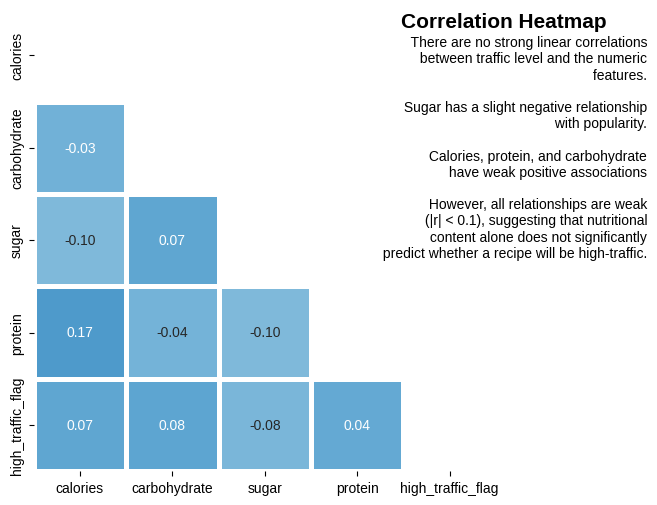

In [ ]:
# Define numeric columns to test
pb_results = []

# Run pointbiserialr and collect results
for col in num_cols:
    r, p = pointbiserialr(df['high_traffic_flag'], df[col])
    pb_results.append((col, r, p))

# Create heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(corr_matrix, mask=mask, cmap='Blues', vmin=-1, vmax=1, center=0,
            square=True, linewidths=2.5, annot=True, fmt=".2f", cbar=False)

# Title
fig.text(0.74, 0.85, 'Correlation Heatmap', fontweight='bold', fontsize=15)

# Insight from visual correlation
fig.text(1.15, 0.44,
         '''
         There are no strong linear correlations
         between traffic level and the numeric
         features.

         Sugar has a slight negative relationship
         with popularity.

         Calories, protein, and carbohydrate
         have weak positive associations

         However, all relationships are weak
         (|r| < 0.1), suggesting that nutritional
         content alone does not significantly
         predict whether a recipe will be high-traffic.
         ''', fontsize=10, ha='right')

plt.show()

In [ ]:
pb_results

[('calories',
  np.float64(0.07438204017479885),
  np.float64(0.02606598207196365)),
 ('carbohydrate',
  np.float64(0.08093170187232107),
  np.float64(0.015444390210209373)),
 ('sugar', np.float64(-0.07552695010319967), np.float64(0.02384757381712117)),
 ('protein', np.float64(0.04457494538832421), np.float64(0.18275269423422427))]

## 4. How Does Nutritional Content Affect Popularity?

Nutritional value appears to have some influence on a recipe's popularity, but not in a straightforward way:

- **Calories**: On average, recipes with higher traffic have slightly more calories (12.76%) compared to low-traffic recipes (10.87%). However, both categories span a wide range of caloric values, suggesting that calorie content alone does not strongly determine popularity.

- **Protein & Carbohydrates**: Both nutrients show similar average levels across high- and low-traffic recipes, with overlapping distributions. This implies that protein and carb content are not strong drivers of recipe popularity.

- **Sugar**: Interestingly, low-traffic recipes tend to contain more sugar than high-traffic ones. This may indicate a user preference for healthier, less sugary options — or a tendency for sugar-heavy recipes to be less widely shared or searched.

**Takeaway**: While high-performing recipes tend to have slightly more calories, protein and carb levels show little distinction. Sugar content, however, may negatively correlate with popularity, potentially reflecting health-conscious user behavior.


### Calories

In [ ]:
# Select relevant columns
df_calories = df.loc[:, ["calories", "high_traffic_flag"]]
df_calories['calories_percent'] = round(df_calories['calories'] / df_calories['calories'].max() * 100, 2)

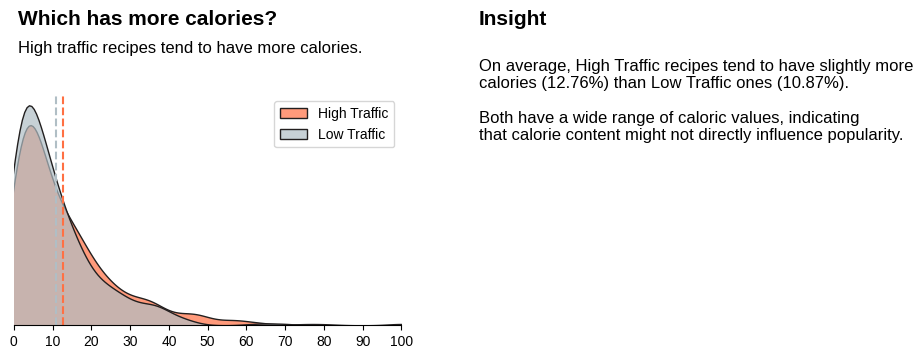

In [ ]:
# Visualizing
plt.figure(figsize=(5, 3))

# Plotting the distribution of calories for high and low traffic recipes using the traffic_palette colors
sns.kdeplot(df_calories["calories_percent"][df_calories.high_traffic_flag == 1],
            color=traffic_palette['High'], fill=True, alpha=0.7, edgecolor='#221f1f')  # High traffic
sns.kdeplot(df_calories["calories_percent"][df_calories.high_traffic_flag == 0],
            color=traffic_palette['Low'], fill=True, alpha=0.7, edgecolor='#221f1f')  # Low traffic

# Setting x-ticks from 0 to 100 with an interval of 10
plt.xticks(np.arange(0, 101, 10))

# Setting x-axis limits
plt.xlim(0, 100)

# Removing ticks and spines
plt.gca().spines[['top', 'right', 'left']].set_visible(False)
plt.tick_params(left=False, labelleft=False)

# Remove x and y axis labels
plt.xlabel('')
plt.ylabel('')

# Calculate and plot mean lines
mean_high_traffic = df_calories["calories_percent"][df_calories.high_traffic_flag == 1].mean()
mean_low_traffic = df_calories["calories_percent"][df_calories.high_traffic_flag == 0].mean()

plt.axvline(x=mean_high_traffic, color=traffic_palette['High'], linestyle='--')
plt.axvline(x=mean_low_traffic, color=traffic_palette['Low'], linestyle='--')

# Adding title and subtitle
plt.text(0.01, 1.3, 'Which has more calories?', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.01, 1.18, 'High traffic recipes tend to have more calories.', fontsize=12, fontweight='light', transform=plt.gca().transAxes)

# Adding legend for High and Low traffic only
plt.legend(['High Traffic', 'Low Traffic'])

# Adding insights
plt.text(1.2, 1.3, 'Insight', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)
plt.text(1.2, 0.65, f'''
On average, High Traffic recipes tend to have slightly more
calories ({mean_high_traffic:.2f}%) than Low Traffic ones ({mean_low_traffic:.2f}%).

Both have a wide range of caloric values, indicating
that calorie content might not directly influence popularity.

        ''', fontsize=12, fontweight='light', transform=plt.gca().transAxes)

plt.show()

### Protein

<ipython-input-203-ec242f9c98ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protein['protein_percent'] = round(df_protein['protein'] / df_protein['protein'].max() * 100, 2)


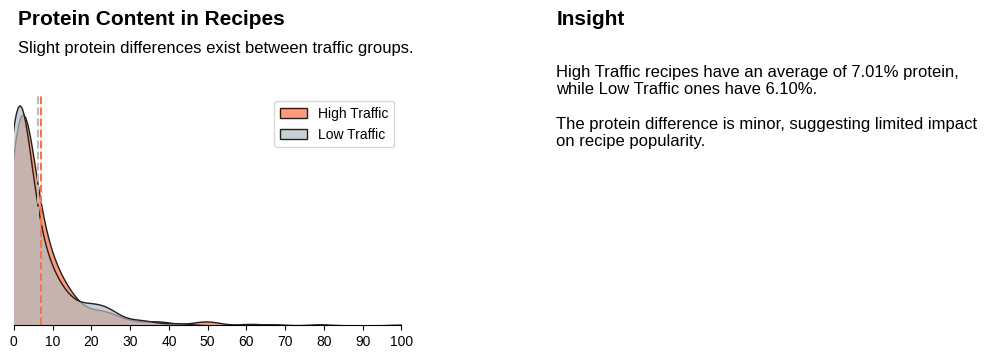

In [ ]:
# Select relevant columns
df_protein = df.loc[:, ["protein", "high_traffic_flag"]]
df_protein['protein_percent'] = round(df_protein['protein'] / df_protein['protein'].max() * 100, 2)

# Visualizing
plt.figure(figsize=(5, 3))
sns.kdeplot(df_protein["protein_percent"][df_protein.high_traffic_flag == 1],
            color=traffic_palette['High'], fill=True, alpha=0.7, edgecolor='#221f1f')
sns.kdeplot(df_protein["protein_percent"][df_protein.high_traffic_flag == 0],
            color=traffic_palette['Low'], fill=True, alpha=0.7, edgecolor='#221f1f')

plt.xticks(np.arange(0, 101, 10))
plt.xlim(0, 100)
plt.tick_params(left=False, labelleft=False)
plt.gca().spines[['top', 'right', 'left']].set_visible(False)
plt.xlabel('')
plt.ylabel('')

mean_high = df_protein["protein_percent"][df_protein.high_traffic_flag == 1].mean()
mean_low = df_protein["protein_percent"][df_protein.high_traffic_flag == 0].mean()
plt.axvline(x=mean_high, color=traffic_palette['High'], linestyle='--')
plt.axvline(x=mean_low, color=traffic_palette['Low'], linestyle='--')

plt.text(0.01, 1.3, 'Protein Content in Recipes', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.01, 1.18, 'Slight protein differences exist between traffic groups.',
         fontsize=12, fontweight='light', transform=plt.gca().transAxes)

plt.legend(['High Traffic', 'Low Traffic'])

plt.text(1.4, 1.3, 'Insight', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)
plt.text(1.4, 0.7, f'''
High Traffic recipes have an average of {mean_high:.2f}% protein,
while Low Traffic ones have {mean_low:.2f}%.

The protein difference is minor, suggesting limited impact
on recipe popularity.
        ''', fontsize=12, fontweight='light', transform=plt.gca().transAxes)

plt.show()

### Carbohydrates

<ipython-input-204-75d11fbb78a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_carb['carb_percent'] = round(df_carb['carbohydrate'] / df_carb['carbohydrate'].max() * 100, 2)


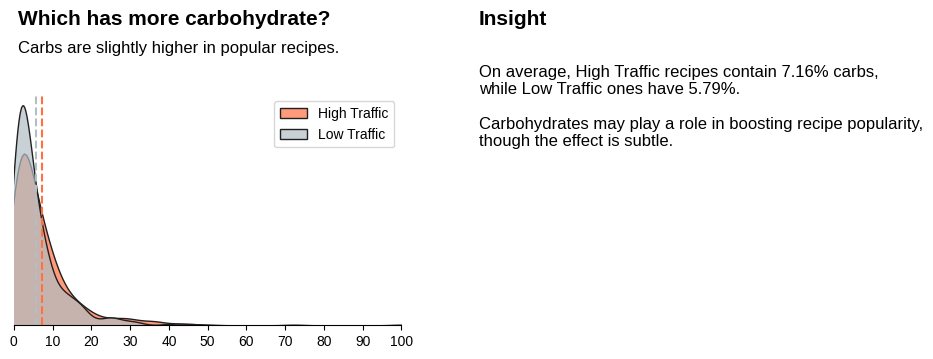

In [ ]:
# Select relevant columns
df_carb = df.loc[:, ["carbohydrate", "high_traffic_flag"]]
df_carb['carb_percent'] = round(df_carb['carbohydrate'] / df_carb['carbohydrate'].max() * 100, 2)

plt.figure(figsize=(5, 3))
sns.kdeplot(df_carb["carb_percent"][df_carb.high_traffic_flag == 1],
            color=traffic_palette['High'], fill=True, alpha=0.7, edgecolor='#221f1f')
sns.kdeplot(df_carb["carb_percent"][df_carb.high_traffic_flag == 0],
            color=traffic_palette['Low'], fill=True, alpha=0.7, edgecolor='#221f1f')

plt.xticks(np.arange(0, 101, 10))
plt.xlim(0, 100)
plt.tick_params(left=False, labelleft=False)
plt.gca().spines[['top', 'right', 'left']].set_visible(False)
plt.xlabel('')
plt.ylabel('')

mean_high = df_carb["carb_percent"][df_carb.high_traffic_flag == 1].mean()
mean_low = df_carb["carb_percent"][df_carb.high_traffic_flag == 0].mean()
plt.axvline(x=mean_high, color=traffic_palette['High'], linestyle='--')
plt.axvline(x=mean_low, color=traffic_palette['Low'], linestyle='--')

plt.text(0.01, 1.3, 'Which has more carbohydrate?', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.01, 1.18, 'Carbs are slightly higher in popular recipes.',
         fontsize=12, fontweight='light', transform=plt.gca().transAxes)

plt.legend(['High Traffic', 'Low Traffic'])

plt.text(1.2, 1.3, 'Insight', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)
plt.text(1.2, 0.7, f'''
On average, High Traffic recipes contain {mean_high:.2f}% carbs,
while Low Traffic ones have {mean_low:.2f}%.

Carbohydrates may play a role in boosting recipe popularity,
though the effect is subtle.
        ''', fontsize=12, fontweight='light', transform=plt.gca().transAxes)

plt.show()

### Sugar

<ipython-input-205-855ee8e879fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sugar['sugar_percent'] = round(df_sugar['sugar'] / df_sugar['sugar'].max() * 100, 2)


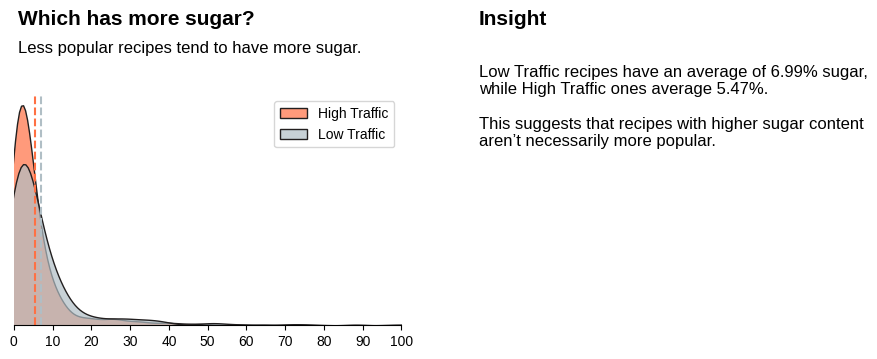

In [ ]:
# Select relevant columns
df_sugar = df.loc[:, ["sugar", "high_traffic_flag"]]
df_sugar['sugar_percent'] = round(df_sugar['sugar'] / df_sugar['sugar'].max() * 100, 2)

plt.figure(figsize=(5, 3))
sns.kdeplot(df_sugar["sugar_percent"][df_sugar.high_traffic_flag == 1],
            color=traffic_palette['High'], fill=True, alpha=0.7, edgecolor='#221f1f')
sns.kdeplot(df_sugar["sugar_percent"][df_sugar.high_traffic_flag == 0],
            color=traffic_palette['Low'], fill=True, alpha=0.7, edgecolor='#221f1f')

plt.xticks(np.arange(0, 101, 10))
plt.xlim(0, 100)
plt.tick_params(left=False, labelleft=False)
plt.gca().spines[['top', 'right', 'left']].set_visible(False)
plt.xlabel('')
plt.ylabel('')

mean_high = df_sugar["sugar_percent"][df_sugar.high_traffic_flag == 1].mean()
mean_low = df_sugar["sugar_percent"][df_sugar.high_traffic_flag == 0].mean()
plt.axvline(x=mean_high, color=traffic_palette['High'], linestyle='--')
plt.axvline(x=mean_low, color=traffic_palette['Low'], linestyle='--')

plt.text(0.01, 1.3, 'Which has more sugar?', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.01, 1.18, 'Less popular recipes tend to have more sugar.',
         fontsize=12, fontweight='light', transform=plt.gca().transAxes)

plt.legend(['High Traffic', 'Low Traffic'])

plt.text(1.2, 1.3, 'Insight', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)
plt.text(1.2, 0.7, f'''
Low Traffic recipes have an average of {mean_low:.2f}% sugar,
while High Traffic ones average {mean_high:.2f}%.

This suggests that recipes with higher sugar content
aren’t necessarily more popular.
        ''', fontsize=12, fontweight='light', transform=plt.gca().transAxes)

plt.show()

## 5. Category Popularity - Which recipe category has the highest impact on traffic level?

The analysis of how recipe categories impact traffic levels reveals key insights into which categories are driving user engagement:

* **High-Traffic Categories**: Certain categories, such as *Potato* (93.98%) and *Vegetable* (98.72%), are significantly contributing to high traffic, with the majority of recipes in these categories being highly popular. These categories stand out as strong drivers of user engagement, suggesting that recipes in these categories resonate well with users and attract substantial attention.

* **Low-Traffic Categories**: Some categories, like *Beverages* (94.57%) and *Breakfast* (68.87%), have a higher proportion of low-traffic recipes. While these categories still represent a considerable part of the recipe database, they do not perform as well in terms of driving high engagement. This indicates that these categories may benefit from strategies to improve their visibility and user appeal.

* **Balanced Categories**: Categories like *Chicken* (42.33% high traffic) and *Dessert* (62.34% high traffic) display a more balanced split between high and low traffic recipes. These categories perform moderately well, but there is still room for improvement in increasing the proportion of high-traffic recipes.

* **Statistical Insight**: A chi-square test of independence confirms that recipe category and traffic level are significantly associated (χ² = 303.74, p = 0.0000). This means that the likelihood of a recipe being high- or low-traffic is not random across categories — some categories are statistically more likely to drive engagement.

In conclusion, categories like *Potato*, *Vegetable*, and *Pork* are driving the most traffic, with their high-traffic recipes far outweighing low-traffic ones. Meanwhile, categories like *Beverages* and *Breakfast* might need some adjustments in their content or presentation to increase their visibility and attract more high-traffic recipes.

,Low Traffic,High Traffic
category,,
Beverages,94.565217,5.434783
Breakfast,68.867925,31.132075
Chicken,57.668712,42.331288
Dessert,37.662338,62.337662
Lunch/Snacks,36.585366,63.414634
Meat,24.324324,75.675676
One Dish Meal,23.880597,76.119403
Pork,9.589041,90.410959
Potato,6.024096,93.975904


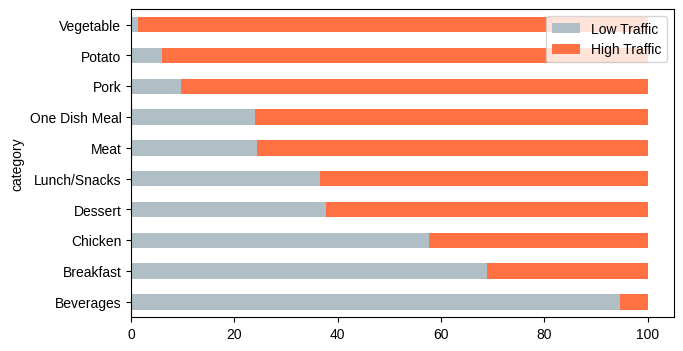

In [ ]:
# Proportions for the stacked bar plot
category_props = pd.crosstab(df['category'], df['high_traffic_flag'], normalize='index') * 100
category_props.columns = ['Low Traffic', 'High Traffic']

category_props

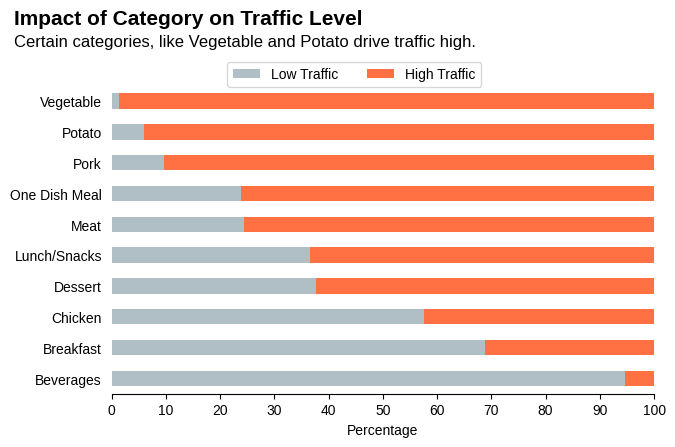

In [ ]:
# Create figure and plot the stacked bar chart (horizontal)
category_props.sort_values('High Traffic').plot(kind='barh', stacked=True,
                                                color=[traffic_palette['Low'],
                                                       traffic_palette['High']],
                                                figsize=(7, 4))

# Setting x-ticks from 10 to 100 with an interval of 10
plt.xticks(np.arange(0, 101, 10))

# Setting x-axis limits
plt.xlim(0, 100)

plt.ylabel('')
plt.xlabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='', loc='upper left', bbox_to_anchor=(0.2, 1.1), ncol=2)  # Two-column legend

# Remove unnecessary spines and ticks for bar chart
plt.gca().spines[['top', 'right', 'left']].set_visible(False)
plt.tick_params(left=False)

plt.text(-0.18, 1.2, 'Impact of Category on Traffic Level', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)
plt.text(-0.18, 1.13, 'Certain categories, like Vegetable and Potato drive traffic high.',
         fontsize=12, fontweight='light', transform=plt.gca().transAxes)

plt.show()

In [ ]:
category_props.round(2)

,Low Traffic,High Traffic
category,,
Beverages,94.57,5.43
Breakfast,68.87,31.13
Chicken,57.67,42.33
Dessert,37.66,62.34
Lunch/Snacks,36.59,63.41
Meat,24.32,75.68
One Dish Meal,23.88,76.12
Pork,9.59,90.41
Potato,6.02,93.98


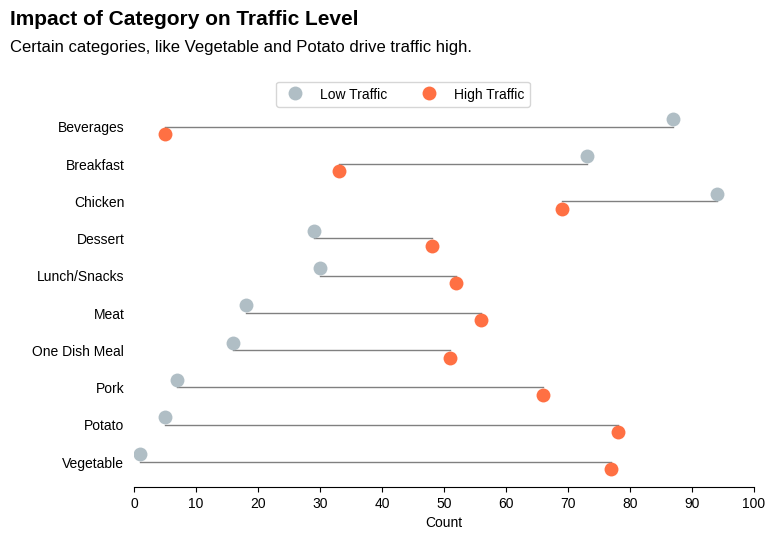

In [ ]:
# Get counts for the dot plot
category_dot = pd.crosstab(df['category'], df['high_traffic_flag']).reset_index()
category_dot.columns = ['category', 'Low Traffic', 'High Traffic']

# Melt to long format for dot plot
dot_data = category_dot.melt(id_vars='category', var_name='Traffic Level', value_name='Count')

# Create figure and plot the dot plot
plt.figure(figsize=(8, 5))

# Strip plot for dot plot
sns.stripplot(data=dot_data, x='Count', y='category', hue='Traffic Level', size=10, jitter=False, dodge=True, palette=[traffic_palette['Low'], traffic_palette['High']])

# Setting x-ticks from 10 to 100 with an interval of 10
plt.xticks(np.arange(0, 101, 10))

# Setting x-axis limits
plt.xlim(0, 100)

# Add lines between the two traffic levels per category
for _, row in category_dot.iterrows():
    plt.plot([row['Low Traffic'], row['High Traffic']], [row['category']] * 2, color='gray', linewidth=1)

plt.xlabel('Count')
plt.ylabel('')
plt.legend(title='', loc='upper right',bbox_to_anchor=(0.65, 1.07), ncol=2)  # Two-column legend

# Remove unnecessary spines and ticks for dot plot
plt.gca().spines[['top', 'right', 'left']].set_visible(False)
plt.tick_params(left=False)

plt.text(-0.2, 1.2, 'Impact of Category on Traffic Level', fontsize=15, fontweight='bold', transform=plt.gca().transAxes)
plt.text(-0.2, 1.13, 'Certain categories, like Vegetable and Potato drive traffic high.', fontsize=12, fontweight='light', transform=plt.gca().transAxes)

plt.show()

In [ ]:
category_dot

,category,Low Traffic,High Traffic
0,Beverages,87,5
1,Breakfast,73,33
2,Chicken,94,69
3,Dessert,29,48
4,Lunch/Snacks,30,52
5,Meat,18,56
6,One Dish Meal,16,51
7,Pork,7,66
8,Potato,5,78
9,Vegetable,1,77


In [ ]:
# Chi-Square Statistical Test of Association
# Contingency table
contingency_table_cat = pd.crosstab(df['category'], df['high_traffic_flag'])

# Perform Chi-squared test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table_cat)

print(f'Chi-square statistic = {chi2_stat:.2f}, p-value = {p_val:.4f}')

if p_val < 0.05:
    print("There is significant association between recipe category and traffic level")
else:
    print("There is no significant association between recipe category and traffic level")

Chi-square statistic = 303.74, p-value = 0.0000
There is significant association between recipe category and traffic level


## 6. Does Recipe Servings Impact Traffic?

While servings of 6 had the highest proportion of high-traffic recipes (63.78%), the differences across servings categories were not substantial. For instance, recipes serving 1 and 2 also had a near-even split between high and low traffic.

To assess whether this variation is statistically meaningful, I performed a chi-square test of independence. The result (χ² = 2.20, p = 0.5311) indicates no significant association between recipe servings and traffic level.

**Conclusion:**
The number of servings does not appear to significantly influence whether a recipe receives high or low traffic. Recipe popularity on Tasty Bytes is likely driven more by other factors such as category or content rather than serving size.

In [ ]:
# Count traffic levels within each servings category
category_traffic_servings = pd.crosstab(df['servings'], df['high_traffic_flag'], normalize='index') * 100
category_traffic_servings.columns = ['Low Traffic', 'High Traffic']

category_traffic_servings = category_traffic_servings.sort_index(ascending=False)

category_traffic_servings.round(2)

,Low Traffic,High Traffic
servings,,
6,36.22,63.78
4,40.05,59.95
2,43.68,56.32
1,41.42,58.58


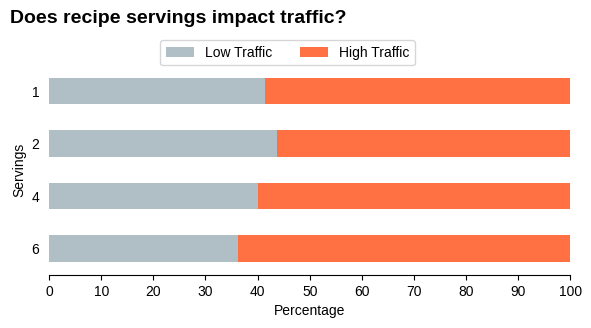

In [ ]:
# Plot stacked bar chart
category_traffic_servings.plot(kind='barh', stacked=True, color=[traffic_palette['Low'], traffic_palette['High']], figsize=(6, 3.5))

plt.xlabel('Percentage')
plt.ylabel('Servings')

# Setting x-ticks from 10 to 100 with an interval of 10
plt.xticks(np.arange(0, 101, 10))

# Setting x-axis limits
plt.xlim(0, 100)

# Remove unnecessary spines and ticks for dot plot
plt.gca().spines[['top', 'right', 'left']].set_visible(False)
plt.tick_params(left=False)
plt.legend(title='', loc='upper left', bbox_to_anchor=(0.2, 1.15), ncol=2)

plt.text(-0.075, 1.2, 'Does recipe servings impact traffic?', fontsize=14, fontweight='bold', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [ ]:
# Chi-Square Statistical Test of Association
# Contingency table
contingency_table_servings = pd.crosstab(df['servings'], df['high_traffic_flag'])

# Perform Chi-squared test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table_servings)

print(f'Chi-square statistic = {chi2_stat:.2f}, p-value = {p_val:.4f}')

if p_val < 0.05:
    print("There is significant association between recipe servings and traffic level.")
else:
    print("There is no significant association between recipe servings and traffic level.")

Chi-square statistic = 2.20, p-value = 0.5311
There is no significant association between recipe servings and traffic level.


## 7. Interaction Effect

Upon examining potential interaction effects between the numerical variables (calories, carbohydrate, sugar, protein, servings) and the categorical variable (category) in relation to traffic levels, the following insights were observed:

1. **Numerical × Numerical Interactions**:
   There were no significant interaction effects (p < 0.05) between the numerical variables. This indicates that the combination of the numerical variables does not significantly impact the traffic levels.

2. **Numerical × Categorical Interactions**:
   Similarly, no significant interaction effects (p < 0.05) were found between the numerical variables (sugar, protein, servings, calories) and the categorical variable (category). This suggests that while the individual effects of the numerical and categorical variables may be significant, their combined effect on traffic levels does not show strong evidence of interaction.

In conclusion, based on this analysis, we did not find significant interaction effects between either the numerical variables themselves or between the numerical and categorical variables in relation to traffic levels.

In [ ]:
numerical_vars = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
all_interactions = []

for var1, var2 in combinations(numerical_vars, 2):
    formula = f'high_traffic_flag ~ {var1} + {var2} + {var1}:{var2}'
    model = smf.logit(formula, data=df).fit(disp=0)

    # Store significant ones
    pval = model.pvalues.get(f'{var1}:{var2}', None)
    if pval is not None and pval < 0.05:
        all_interactions.append((f'{var1}:{var2}', round(pval, 4)))

# Check if there are any significant interaction terms
if not all_interactions:
    print("There are no significant interaction effects (p < 0.05) between the numerical variables.")
else:
    print("Significant interaction terms (p < 0.05):")
    for term, pval in all_interactions:
        print(f"{term}: p-value = {pval}")

There are no significant interaction effects (p < 0.05) between the numerical variables.


In [ ]:
categorical_vars = ['category']
all_interactions = []

for num_var in numerical_vars:
    for cat_var in categorical_vars:
        formula = f'high_traffic_flag ~ {num_var} + {cat_var} + {num_var}:{cat_var}'
        model = smf.logit(formula, data=df).fit(disp=0)

        # Store significant ones
        pval = model.pvalues.get(f'{num_var}:{cat_var}', None)
        if pval is not None and pval < 0.05:
            all_interactions.append((f'{num_var}:{cat_var}', round(pval, 4)))

# Check if there are any significant interaction terms
if not all_interactions:
    print("There are no significant interaction effects (p < 0.05) between the numerical and categorical variables.")
else:
    print("Significant interaction terms (p < 0.05):")
    for term, pval in all_interactions:
        print(f"{term}: p-value = {pval}")

There are no significant interaction effects (p < 0.05) between the numerical and categorical variables.


# Feature Engineering

## 1. Average Nutrientional value per category

To capture category-level nutritional patterns, we created new features representing the average nutritional content per category. This helps the model understand the relationship between a recipe’s category and its nutritional values.

In [ ]:
# Compute average nutritional values per category
category_nutrient_avg = df.groupby('category')[['calories', 'carbohydrate', 'sugar', 'protein']].mean().round(2).add_prefix('avg_')

# Merge with original dataframe
df = df.merge(category_nutrient_avg, left_on='category', right_index=True, how='left')

In [ ]:
category_nutrient_avg

,avg_calories,avg_carbohydrate,avg_sugar,avg_protein
category,,,,
Beverages,177.73,15.96,12.54,0.59
Breakfast,331.88,39.71,7.55,16.96
Chicken,551.51,25.61,5.34,47.79
Dessert,351.40,55.66,35.23,5.76
Lunch/Snacks,478.85,42.82,5.31,19.61
Meat,584.53,22.16,5.81,40.38
One Dish Meal,579.09,50.38,6.01,35.93
Pork,629.71,28.08,8.04,43.80
Potato,425.07,58.15,3.72,8.57


# Clustering

Clustering can help identify groups of recipes with similar characteristics, which can lead to insights for personalized recommendations, content strategies, or even predicting traffic behavior based on features like nutritional content.

In [ ]:
# Preprocessing features
# Step 1: Select relevant features for clustering
# (We'll use both original and category-level features, excluding the traffic label and IDs)
clustering_features = ['calories', 'carbohydrate', 'sugar', 'protein',
                       'avg_calories', 'avg_carbohydrate', 'avg_sugar', 'avg_protein']

# Step 2: Log-transform the original skewed nutritional features
log_transform_cols = ['calories', 'carbohydrate', 'sugar', 'protein']
for col in log_transform_cols:
    df[f'log_{col}'] = np.log1p(df[col])

# Step 3: Scale all features (log-transformed + category-level averages)
scaling_features = [f'log_{col}' for col in log_transform_cols] + [
    'avg_calories', 'avg_carbohydrate', 'avg_sugar', 'avg_protein'
]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[scaling_features])

# Step 4: Store in a DataFrame for easy interpretation
scaled_df = pd.DataFrame(scaled_data, columns=[f'scaled_{col}' for col in scaling_features])

scaled_df.head()

,scaled_log_calories,scaled_log_carbohydrate,scaled_log_sugar,scaled_log_protein,scaled_avg_calories,scaled_avg_carbohydrate,scaled_avg_sugar,scaled_avg_protein
0,-1.430932,0.586273,-1.260148,-1.342748,-0.075066,1.655410,-0.636905,-0.891792
1,1.035308,0.672745,-0.347776,-0.811009,-0.718720,0.332800,-0.178908,-0.411506
2,-0.674399,0.389077,1.950075,-1.820831,-1.783418,-1.370669,0.417802,-1.348607
3,-1.632041,-1.709688,-1.178223,-1.514366,-1.783418,-1.370669,0.417802,-1.348607
4,0.821455,-1.318812,-0.786884,1.192126,0.988734,1.098106,-0.363064,0.674432


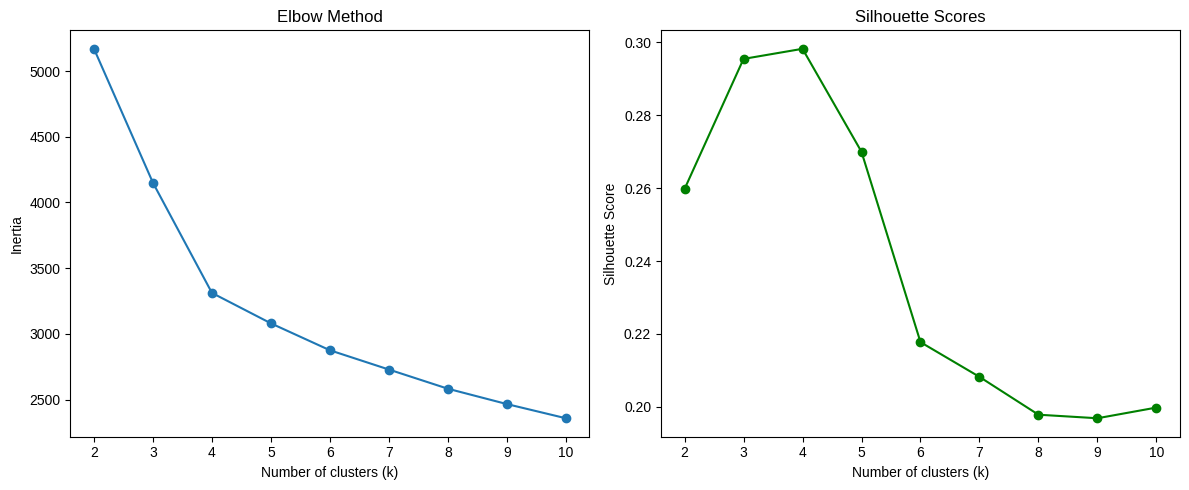

In [ ]:
# Clustering
# Step 1: Decide the range of k to try
k_values = range(2, 11)
inertia = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))

# Step 2: Plot the Elbow and Silhouette Score to choose optimal k
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
final_k = 3

# Initialize and fit KMeans
final_kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(scaled_df)

# Add the cluster labels to the original dataframe
df['recipe_cluster'] = cluster_labels

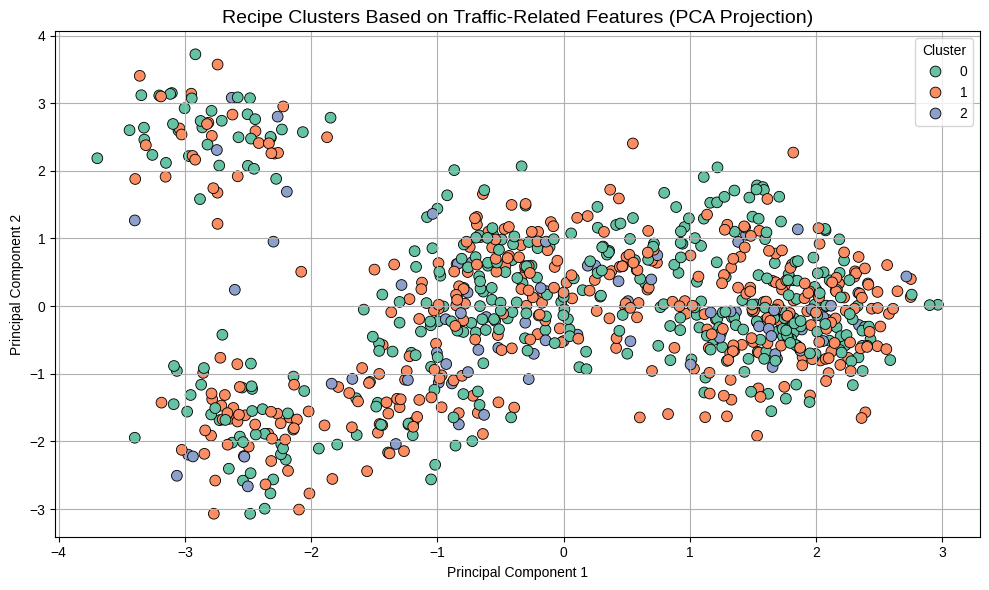

In [ ]:
# Reduce to 2 principal components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['recipe_cluster'].astype(str)

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60, edgecolor='k')
plt.title('Recipe Clusters Based on Traffic-Related Features (PCA Projection)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# View cluster summary
# Helper functions
def top_category(x):
    return x.value_counts().index[0]

def top_servings(x):
    return x.value_counts().index[0]

# Group by both traffic flag and cluster
grouped = df.groupby(['high_traffic_flag', 'recipe_cluster'])

# Compute mean nutritional values
nutritional_means = grouped[['calories', 'carbohydrate', 'sugar', 'protein']].mean().round(2)

# Compute top category and servings
category_mode = grouped['category'].agg(top_category)
servings_mode = grouped['servings'].agg(top_servings)

# Combine all results
recipe_cluster_traffic = pd.concat([
    nutritional_means,
    category_mode.rename('top_category'),
    servings_mode.rename('common_servings')
], axis=1)

# Final table
recipe_cluster_traffic.reset_index(inplace=True)
recipe_cluster_traffic.set_index(['high_traffic_flag', 'recipe_cluster'], inplace=True)

# View the table
recipe_cluster_traffic

calories  carbohydrate  sugar  protein  \
high_traffic_flag recipe_cluster                                           
0                 0                 270.33         29.24   9.55     8.41   
                  1                 563.46         28.30   5.83    41.89   
                  2                 300.34         52.65  39.27     6.12   
1                 0                 328.89         40.30   5.16     9.61   
                  1                 597.19         32.34   6.19    43.14   
                  2                 382.25         57.48  32.78     5.54   

                                 top_category  common_servings  
high_traffic_flag recipe_cluster                                
0                 0                 Beverages                4  
                  1                   Chicken                4  
                  2                   Dessert                4  
1                 0                    Potato                4  
                  1                   Chicken                4  
                  2                   Dessert                4

In [ ]:
# Statistical testing of differences in traffic level between clusters
contigency_table_clusters = pd.crosstab(df['recipe_cluster'], df['high_traffic_flag'])

# Perform Chi-squared test
chi2_stat, p_val, dof, expected = chi2_contingency(contigency_table_clusters)

print(f'Chi-square statistic = {chi2_stat:.2f}, p-value = {p_val:.4f}')

if p_val < 0.05:
    print("There is significant association between recipe cluster and traffic level.")

else:
    print("There is no significant association between recipe cluster and traffic level.")

Chi-square statistic = 5.12, p-value = 0.0775
There is no significant association between recipe cluster and traffic level.


# Data Preprocessing - Preparing the Data For Modeling

## 1. One-Hot Encoding the Catgory feature
Since category represents different food types with no inherent order, One-Hot Encoding is a good choice here.

In [ ]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['category'], drop_first=True)

In [ ]:
df_encoded.head()

,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic_flag,avg_calories,avg_carbohydrate,avg_sugar,avg_protein,log_calories,log_carbohydrate,log_sugar,log_protein,recipe_cluster,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
1,2,35.48,38.56,0.66,0.92,4,1,425.07,58.15,3.72,8.57,3.596764,3.677819,0.506818,0.652325,0,False,False,False,False,False,False,False,True,False
2,3,914.28,42.68,3.09,2.88,1,0,331.88,39.71,7.55,16.96,6.819230,3.776890,1.408545,1.355835,0,True,False,False,False,False,False,False,False,False
3,4,97.03,30.56,38.63,0.02,4,1,177.73,15.96,12.54,0.59,4.585274,3.451890,3.679586,0.019803,0,False,False,False,False,False,False,False,False,False
4,5,27.05,1.85,0.80,0.53,4,0,177.73,15.96,12.54,0.59,3.333989,1.047319,0.587787,0.425268,0,False,False,False,False,False,False,False,False,False
5,6,691.15,3.46,1.65,53.93,2,1,579.09,50.38,6.01,35.93,6.539803,1.495149,0.974560,4.006060,1,False,False,False,False,False,True,False,False,False


## 2. Test For Normality For Numerical (Nutritional content) Features

Performed tests for normality on the nutritional columns to assess whether the data follows a normal distribution.

**Hypotheses:**

- Null Hypothesis (H0): The data follow a normal distribution.
- Alternative Hypothesis (H1): The data do not follow a normal distribution.

**Result of the Test**

- **Q-Q Plot:** Each feature's data points visibly deviated from the reference line, indicating non-normality.
  
- **Shapiro-Wilk Test:** Extremely small p-values (p ≈ 0.000) for all features led to rejection of the null hypothesis, confirming non-normal distributions.

- **Anderson-Darling Test:** All test statistics exceeded the critical values at standard significance levels, further confirming non-normality.

**Preprocessing Actions Taken:**

* **Winsorization:** Applied to cap extreme values at the 1st and 99th percentiles, reducing the impact of outliers while preserving most of the data structure.
* **Log Transformation:** A `log1p` transformation was used to correct right-skewness and stabilize variance.
* **Scaling:** After transformation, features were standardized using `StandardScaler` to ensure comparability in model training.

**Conclusion:**

The combination of winsorization, log transformation, and standard scaling addressed both skewness and outliers effectively, preparing the features for reliable modeling.

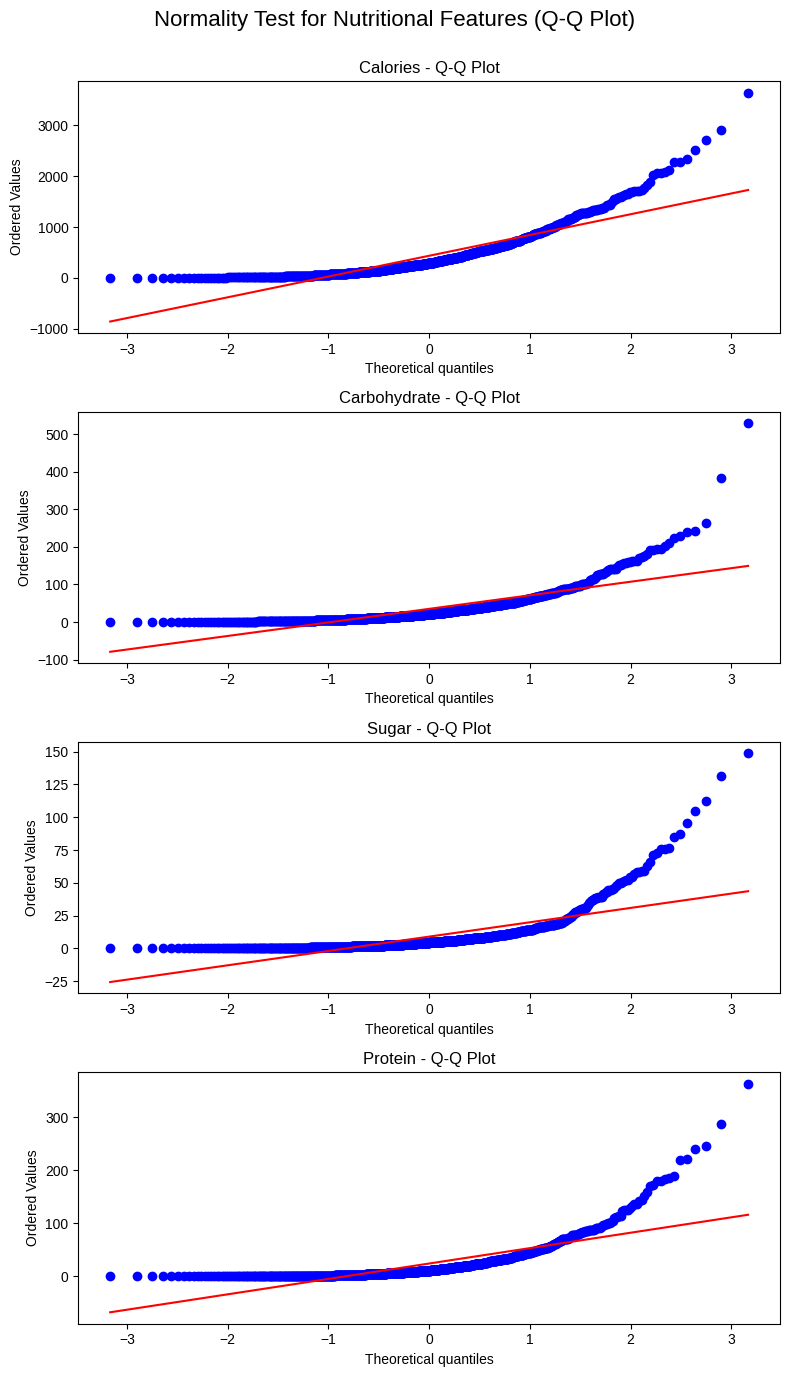

In [ ]:
# Set up subplots for the Q-Q plot
fig, axes = plt.subplots(len(nutrients), 1, figsize=(8, 14))
fig.suptitle('Normality Test for Nutritional Features (Q-Q Plot)', fontsize=16)
fig.subplots_adjust(hspace=0.4)

for i, nutrient in enumerate(nutrients):
    # Q-Q plot
    stats.probplot(df[nutrient].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'{nutrient.capitalize()} - Q-Q Plot')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [ ]:
# Perform Shapiro-Wilk test and Anderson-Darling test for normality
normality_results = {}

for nutrient in nutrients:
    # Shapiro-Wilk test
    shapiro_stat, shapiro_p_value = stats.shapiro(df[nutrient])

    # Anderson-Darling test
    anderson_result = stats.anderson(df[nutrient], dist='norm')

    normality_results[nutrient] = {
        'Shapiro-Wilk p-value': shapiro_p_value,
        'Anderson-Darling stat': anderson_result.statistic,
        'Anderson-Darling critical values': anderson_result.critical_values
    }

# Display results
normality_results

{'calories': {'Shapiro-Wilk p-value': np.float64(2.132307257197235e-31),
  'Anderson-Darling stat': np.float64(44.964014926317304),
  'Anderson-Darling critical values': array([0.573, 0.653, 0.784, 0.914, 1.087])},
 'carbohydrate': {'Shapiro-Wilk p-value': np.float64(3.826676525093782e-38),
  'Anderson-Darling stat': np.float64(68.61753453178494),
  'Anderson-Darling critical values': array([0.573, 0.653, 0.784, 0.914, 1.087])},
 'sugar': {'Shapiro-Wilk p-value': np.float64(1.0180754029722553e-42),
  'Anderson-Darling stat': np.float64(114.48701543246125),
  'Anderson-Darling critical values': array([0.573, 0.653, 0.784, 0.914, 1.087])},
 'protein': {'Shapiro-Wilk p-value': np.float64(8.570082269905578e-40),
  'Anderson-Darling stat': np.float64(89.3286791841249),
  'Anderson-Darling critical values': array([0.573, 0.653, 0.784, 0.914, 1.087])}}

## Preprocessing Pipeline

In [ ]:
# Define a custom transformer for Winsorizing
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=(0.05, 0.95)):
        self.limits = limits

    def fit(self, X, y=None):
        self.lower_limits = X.quantile(self.limits[0])
        self.upper_limits = X.quantile(self.limits[1])
        return self

    def transform(self, X):
        X_winsorized = X.copy()
        for col in X.columns:
            X_winsorized[col] = np.clip(X[col], self.lower_limits[col], self.upper_limits[col])
        return X_winsorized

In [ ]:
# Select numerical and other columns
numerical_cols = ['calories', 'carbohydrate', 'sugar', 'protein', 'avg_calories', 'avg_carbohydrate', 'avg_sugar', 'avg_protein']
other_cols = [col for col in df_encoded.columns if col not in (numerical_cols + ['recipe', 'high_traffic_flag'])]

# Step 1: Split the data into train and test sets
X = df_encoded.drop(columns=['recipe', 'high_traffic_flag'])  # Features
y = df_encoded['high_traffic_flag']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Pipeline for numeric features
numeric_pipeline = Pipeline(steps=[
    ('winsorize', Winsorizer()),
    ('log1p', FunctionTransformer(np.log1p, validate=True)),
    ('scale', StandardScaler())
])

# Step 3: ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numerical_cols)
    ],
    remainder='passthrough'  # Keep other columns unchanged
)

# Step 4: Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the training data, transform the test data
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Convert transformed data back to DataFrame for easier inspection
transformed_columns = numerical_cols + other_cols
X_train_transformed = pd.DataFrame(X_train_transformed, columns=transformed_columns)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=transformed_columns)

In [ ]:
X_train_transformed.head()

,calories,carbohydrate,sugar,protein,avg_calories,avg_carbohydrate,avg_sugar,avg_protein,servings,log_calories,log_carbohydrate,log_sugar,log_protein,recipe_cluster,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
0,0.050159,1.022051,2.10471,-0.527089,-0.424525,1.342803,2.890487,-0.928863,4,5.573256,4.113003,4.297149,1.803359,2,False,False,True,False,False,False,False,False,False
1,0.315894,-0.226047,1.735094,1.356352,0.736169,-0.585688,-0.508375,0.982457,2,5.872174,2.794839,3.331133,4.176692,1,False,True,False,False,False,False,False,False,False
2,-0.433098,-0.856096,0.257576,0.993459,0.861894,1.093202,-0.312481,0.71314,4,5.029653,2.129421,1.958685,3.719409,1,False,False,False,False,False,True,False,False,False
3,1.283447,-0.441535,1.238841,-0.546946,0.861894,1.093202,-0.312481,0.71314,2,6.960547,2.567254,2.870169,1.778336,1,False,False,False,False,False,True,False,False,False
4,-1.059593,0.802328,1.221615,1.082728,1.077829,-0.359194,0.183446,0.899953,4,4.324927,3.880945,2.854169,3.831897,1,False,False,False,False,False,False,True,False,False


# Predictive Modeling Approach

This section outlines the thought process and methodology used to develop a robust recipe-popularity prediction model — a classic classification task. The goal is to build a solution that not only performs well technically but also supports meaningful business decisions.

**1. Defining the Business Requirements**

The objective is to predict which recipes will be popular, helping the platform prioritize showing engaging content to users. Specifically, the stakeholders have requested that the model:

* Correctly identify popular recipes **at least 80% of the time**, and
* Minimize the chance of showing unpopular recipes.

While achieving 80% predictive accuracy for popular recipes may not be realistic within our time and resource constraints, my approach will prioritize **precision** — ensuring that when a recipe is predicted to be popular, it's likely to be correct. This will reduce the risk of recommending unpopular recipes, aligning closely with the business goal.

**2. Choosing the Model**

To meet these objectives, I’ll test 2 classification models and compare their results to select the one that best balances precision and overall performance:

* **Logistic Regression**: A simple, interpretable baseline that works well with linearly separable data.
  
* **Random Forest Classifier**: A tree-based model that handles non-linearity well and is robust to overfitting.

Each model will be trained and evaluated using the same preprocessing pipeline and stratified cross-validation to ensure fair and reproducible comparisons.

**3. Defining the Evaluation Metrics**

Given the business focus, I’ll assess model performance using a range of classification metrics, with an emphasis on precision for the “popular” class (label = 1):

* **Precision (Positive Class)**: The primary metric — measures the proportion of recipes predicted as popular that are truly popular. High precision reduces the risk of recommending unpopular recipes.
  
* **Recall (Positive Class)**: Captures how well the model identifies all truly popular recipes.

* **Accuracy**: The overall proportion of correct predictions. Useful as a general reference but less informative when classes are imbalanced.

* **F1 Score**: A balanced metric that combines precision and recall.

* **ROC AUC**: Measures how well the model distinguishes between popular and unpopular recipes across all thresholds.

* **Confusion Matrix**: Provides a breakdown of true/false positives and negatives to help us understand error types.

Together, these metrics will help me select a model that aligns best with the business requirements and provides reliable results.

## Defining Reuseable Functions

In [ ]:
# Evaluation Metrics Function
def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Evaluate the performance of a model on the test set.

    Parameters:
    - model: The trained machine learning model.
    - X_test: Features of the test set.
    - y_test: True labels of the test set.
    - threshold: Threshold for binary classification.

    Returns:
    - Prints the confusion matrix, classification report, ROC-AUC, PR-AUC scores.
    """

    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba).round(2))
    print("\nPR-AUC Score:", average_precision_score(y_test, y_proba).round(2))
    print()

In [ ]:
# Feature Importance Plot Function - works for logistic and other models
def plot_feature_importance(model, X_train):
    """
    Plot the feature importance for a given model.

    Parameters:
    - model: The trained machine learning model.
    - X_train: Features of the training set.

    Returns:
    - Displays a bar plot of feature importance.
    """
    if hasattr(model, 'coef_'):
        feature_importance = model.coef_[0]
    elif hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_

    features = X_train.columns
    importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    importances_df.sort_values(by='Importance', ascending=False, inplace=True)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importances_df, palette='coolwarm',
                hue='Feature')
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

In [ ]:
# Model Tracking Function
model_results = []

def log_model_result(
    model_name, y_test, y_prob, threshold=0.5,
    hyperparams=None, notes=None
):
    """
    Logs detailed info about a model's performance and settings.

    Parameters:
    - model_name (str): Name of the model
    - y_test (array): True labels
    - y_prob (array): Probabilities of the positive class
    - threshold (float): Threshold used to generate y_pred from y_prob
    - hyperparams (dict): Dictionary of hyperparameters used
    - notes (str): Any additional comments or context

    Returns:
    - None
    """
    y_pred = (y_prob >= threshold).astype(int)

    result = {
        "Model": model_name,
        "Threshold": threshold,
        "Precision": round(precision_score(y_test, y_pred), 2),
        "Recall": round(recall_score(y_test, y_pred), 2),
        "Accuracy": round(accuracy_score(y_test, y_pred), 2),
        "F1 Score": round(f1_score(y_test, y_pred), 2),
        "Confusion Matrix": confusion_matrix(y_test, y_pred).tolist(),
        "ROC AUC": round(roc_auc_score(y_test, y_prob), 2),
        "PR AUC": round(average_precision_score(y_test, y_prob), 2),
        "Hyperparameters": json.dumps(hyperparams, separators=(",", ": ")) if hyperparams else "",
        "Notes": notes if notes else ""
    }

    model_results.append(result)

In [ ]:
# View log table function
def get_model_results_df():
    """
    Returns the model tracking results as a DataFrame.
    """
    return pd.DataFrame(model_results)

In [ ]:
# Plot Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, model_name='Model'):
    """
    Plots a customized confusion matrix as a heatmap with group names, counts, and percentages.

    Parameters:
    y_test : array-like, shape (n_samples,)
        True labels or ground truth.
    y_pred : array-like, shape (n_samples,)
        Predicted labels from the model.
    model_name : string, optional (default='Model')
        The title of the model for the plot.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Define group names, counts, and percentages
    group_names = ['True High-Traffic', 'False High-Traffic', 'False Low-Traffic', 'True Low-Traffic']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.1%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    box_labels = [f'{v1}\n\n{v2}\n\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(2, 2)


    # Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=box_labels, fmt='', cmap='Blues_r',
                linewidth=1, cbar=False, vmin=0, vmax=100,
                xticklabels=['Predicted Low-Traffic', 'Predicted High-Traffic'],
                yticklabels=['Actual Low-Traffic', 'Actual High-Traffic'])

    # Customize plot appearance
    plt.gca().xaxis.set_label_position('top')
    plt.gca().xaxis.set_ticks_position('top')
    plt.tick_params(axis='both', length=0)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Confusion Matrix: {model_name}', fontsize=14, fontweight='bold', y=1.09)
    plt.show()

## Baseline Model - Logistic Regression

In [ ]:
# Create the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, class_weight='balanced')

In [ ]:
# Fit the model on the training data
lr_model_v1 = log_reg_model.fit(X_train_transformed, y_train)

# Make Predictions
y_proba_lr_v1 = lr_model_v1.predict_proba(X_test_transformed)[:, 1]
y_pred_lr_v1 = (y_proba_lr_v1 >= 0.5).astype(int)

# Evaluate the model
evaluate_model(lr_model_v1, X_test_transformed, y_test)

Confusion Matrix:
 [[63  9]
 [48 59]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.88      0.69        72
           1       0.87      0.55      0.67       107

    accuracy                           0.68       179
   macro avg       0.72      0.71      0.68       179
weighted avg       0.75      0.68      0.68       179


ROC-AUC Score: 0.83

PR-AUC Score: 0.87



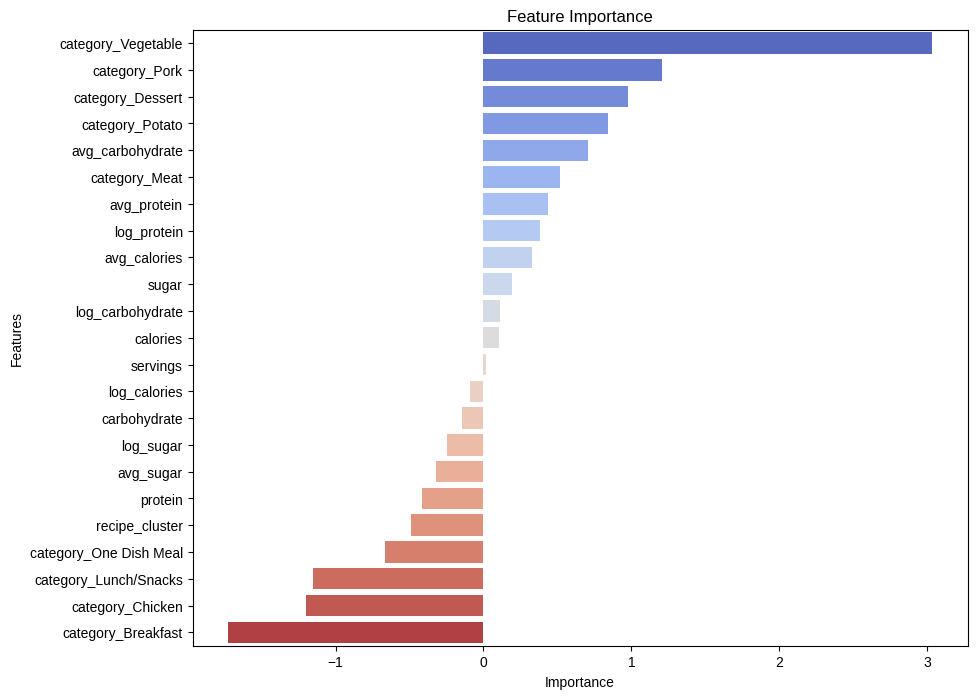

In [ ]:
# Feature importance
plot_feature_importance(lr_model_v1, X_train_transformed)

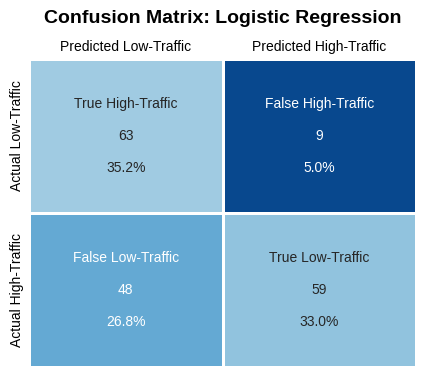

In [ ]:
plot_confusion_matrix(y_test, y_pred_lr_v1, model_name='Logistic Regression')

In [ ]:
# Logging result
log_model_result(
    model_name = 'Logistic Regression',
    y_test=y_test,
    y_prob=y_proba_lr_v1,
    hyperparams={'class_weight':'balanced'},
    notes=(
        "High precision in predicting popular recipes "
        "(exceeds 80% target), but lower recall suggests it "
        "misses a significant number of actual popular ones."
    )
)

## Comparison Model - Random Forest

In [ ]:
# Create the Random Forest model
random_forest = RandomForestClassifier(random_state=42, class_weight='balanced')

In [ ]:
# Fit the model on the training data
rf_model_v1 = random_forest.fit(X_train_transformed, y_train)

# Make Predictions
y_proba_rf_v1 = rf_model_v1.predict_proba(X_test_transformed)[:, 1]
y_pred_rf_v1 = (y_proba_rf_v1 >= 0.5).astype(int)

# Evaluate the model
evaluate_model(rf_model_v1, X_test_transformed, y_test)

Confusion Matrix:
 [[54 18]
 [29 78]]

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.75      0.70        72
           1       0.81      0.73      0.77       107

    accuracy                           0.74       179
   macro avg       0.73      0.74      0.73       179
weighted avg       0.75      0.74      0.74       179


ROC-AUC Score: 0.8

PR-AUC Score: 0.86



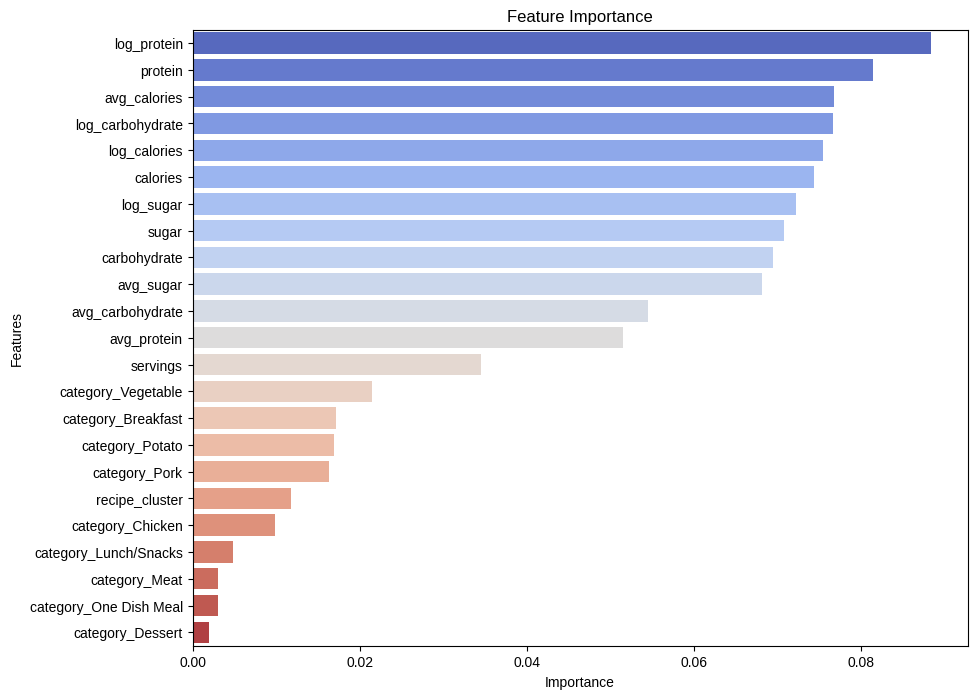

In [ ]:
plot_feature_importance(rf_model_v1, X_train_transformed)

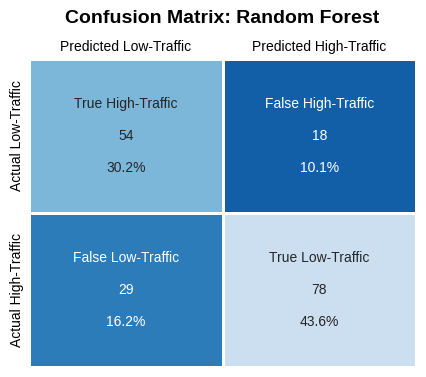

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_test, y_pred_rf_v1, model_name='Random Forest')

In [ ]:
# logging result
log_model_result(
    model_name = 'Random Forest',
    y_test=y_test,
    y_prob=y_proba_rf_v1,
    hyperparams={'class_weight':'balanced'},
    notes=(
        "Balanced performance with solid precision (same as target) "
        "and recall; better at identifying both classes with "
        "stronger overall F1 and AUC scores."
    )
)

## Comparing Both Models

The Random Forest model outperforms Logistic Regression across most metrics, especially in precision, F1-score, and both AUC scores, making it a stronger choice for identifying popular recipes.

In [ ]:
model_log = get_model_results_df()
model_log

,Model,Threshold,Precision,Recall,Accuracy,F1 Score,Confusion Matrix,ROC AUC,PR AUC,Hyperparameters,Notes
0,Logistic Regression,0.5,0.87,0.55,0.68,0.67,"[[63, 9], [48, 59]]",0.83,0.87,"{""class_weight"": ""balanced""}","High precision in predicting popular recipes (exceeds 80% target), but lower recall suggests it misses a significant number of actual popular ones."
1,Random Forest,0.5,0.81,0.73,0.74,0.77,"[[54, 18], [29, 78]]",0.80,0.86,"{""class_weight"": ""balanced""}",Balanced performance with solid precision (same as target) and recall; better at identifying both classes with stronger overall F1 and AUC scores.


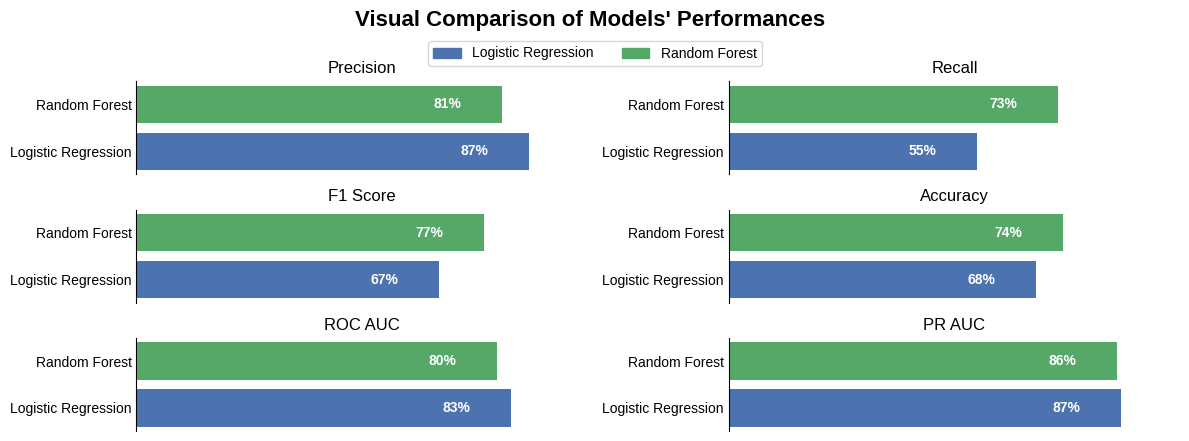

In [ ]:
# Define colors for each model
model_colors = {
    'Logistic Regression': '#4c72b0',  # Slate blue
    'Random Forest': '#55a868',        # Muted green
}

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 4))

# Define the metrics to plot
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy', 'ROC AUC', 'PR AUC']

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    ax.barh(
        model_log['Model'],
        model_log[metric],
        color=[model_colors[model] for model in model_log['Model']]
    )
    ax.set_xlim(0, 1)
    ax.set_xlabel('Score')
    ax.set_title(f'{metric}', fontweight='light')

    # Annotate each bar with its respective score
    for bar in ax.patches:
        ax.annotate(f'{bar.get_width():.0%}',
                    (bar.get_width() - 0.09, bar.get_y() + bar.get_height() / 2),
                    va='center', ha='right', fontsize=10, fontweight='bold', color='white')

    # Clean up axis lines and ticks
    ax.spines[['top', 'right', 'bottom']].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.tick_params(axis='both', length=0)

# Add legend once, outside the loop
handles = [plt.Rectangle((0,0),1,1, color=color) for color in model_colors.values()]
labels = list(model_colors.keys())
fig.legend(handles, labels, title='', loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=2)

# Title
fig.text(0.3, 1.05, "Visual Comparison of Models' Performances", fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

# Business Metric Definition & Monitoring

**Business Goal Recap:**

The goal is to improve the platform’s ability to identify and promote recipes that are likely to become popular — in order to maximize traffic and user engagement from featured content.

**Recommended Monitoring Metric: Promotion Hit Rate (PHR)**

* **Definition**:
  The percentage of promoted recipes that actually become popular. It answers the question:
  "Out of all the recipes we chose to promote, how many ended up getting high traffic?"


* **Why it matters**:
  - Promoting a recipe uses valuable homepage space or marketing resources.

  - If many promoted recipes don’t perform well (i.e., don’t become popular), it’s a sign the selection process needs improvement.

  - A high PHR means the model is accurately helping the business promote high-performing content, boosting traffic and engagement.

* **Formula**:

  $$
  \text{PHR} = \frac{\text{Number of promoted recipes that became popular}}{\text{Total number of promoted recipes}} \times 100
  $$

* **Estimated Initial Value:**
Based on the Random Forest model's precision (80%), the estimated starting value is:
    
 $$
  \text{PHR} = 80%
  $$
         
_"Assuming we promote recipes predicted as popular by the model, we can expect around 80% of them to truly become popular based on test performance."_

This serves as a baseline for future monitoring.

* **Monitoring Plan**:

  - **Frequency**: Weekly/monthly

  - **Dashboard**: KPI tile with PHR, trend line, and breakdown by categories

  - **Alerting Strategy**: Trigger an alert if PHR falls below a critical threshold (e.g., 60%), prompting a review of model performance, or shifts in recipe trends

# Conclusion & Actionable Recommendations

**Conclusion**

After comparing two models — **Logistic Regression** and **Random Forest** — the Random Forest model demonstrated superior performance in key areas like recall, F1-score, and overall predictive reliability (ROC-AUC: 0.80, PR-AUC: 0.85). These results support its use for predicting which recipes are likely to become popular.


**Actionable Recommendations for the Product Team**

**1. Adopt the Random Forest Model for Promotion Decisions**

* Outperformed Logistic Regression, especially in recall and F1-score — critical for catching as many truly popular recipes as possible.
* Its high ROC-AUC and PR-AUC scores indicate a strong ability to distinguish popular from unpopular content.

**2. Promote Only Recipes Predicted as “Popular” by the Model**

* This ensures homepage or marketing space is used for content with high traffic potential.
* Reduces the chance of wasting visibility on underperforming recipes.

**3. Monitor Promotion Hit Rate (PHR)**

* Use **PHR** as the central performance metric for the recipe promotion strategy.
* Track it weekly or monthly via a dashboard with trends and category breakdowns.
* Set up alerts for significant drops (e.g., below 60%) to flag when retraining is needed.

**4. Complement with Engagement Metrics**

* Combine PHR with user-level metrics such as click-through rate (CTR and time on page to understand deeper engagement.
* This provides a holistic view of how promoted content performs beyond just popularity.

**5. Regularly Retrain the Model**

* User preferences and content trends evolve — retrain the model periodically (e.g., quarterly).
* After each retraining, re-evaluate metrics like precision, recall and PHR to ensure continued effectiveness.

**6. Use A/B Testing for Rollout Validation**

* Before full deployment, test the model-driven promotion approach against the existing strategy.
* Analyze differences in traffic, engagement, and PHR to measure the model’s real-world impact.
* Use insights to guide gradual or full adoption.